In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [91]:
import pandas as pd
import numpy as np

import json
import pickle

import typing as tp
from tqdm import tqdm
from collections import Counter

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
!pip install hnswlib
import hnswlib

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel

## Предобработанный KION датасет с заполненными пропусками

In [ ]:
interactions_df = pd.read_csv('/content/drive/MyDrive/RecSys MTC/kion/interactions_processed.csv')
users_df = pd.read_csv('/content/drive/MyDrive/RecSys MTC/kion/users_processed.csv')
items_df = pd.read_csv('/content/drive/MyDrive/RecSys MTC/kion/items_processed.csv')

## Вектора пользователей



In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       840197 non-null  object
 2   income    840197 non-null  object
 3   sex       840197 non-null  object
 4   kids_flg  840197 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 26.4+ MB


In [ ]:
users_cat_feats = ["age", "income", "sex", "kids_flg"]

users_ohe_df = users_df.user_id
for feat in users_cat_feats:
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.shape

(840197, 20)

## Вектора айтемов

In [ ]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   item_id           15963 non-null  int64  
 1   content_type      15963 non-null  object 
 2   title             15963 non-null  object 
 3   title_orig        15963 non-null  object 
 4   genres            15963 non-null  object 
 5   countries         15963 non-null  object 
 6   for_kids          15963 non-null  bool   
 7   age_rating        15963 non-null  float64
 8   studios           15963 non-null  object 
 9   directors         15963 non-null  object 
 10  actors            15963 non-null  object 
 11  description       15963 non-null  object 
 12  keywords          15963 non-null  object 
 13  release_year_cat  15963 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 1.6+ MB


In [ ]:
items_cat_feats = ["content_type", "for_kids", 
                   "age_rating", "studios", 
                   "release_year_cat"]

items_ohe_df = items_df.item_id
for feat in items_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1)

items_ohe_df.shape

(15963, 62)

In [ ]:
# Добавим one-hot encoding жанра и страны

set_genres = set()
for i in range(items_df.shape[0]):
    genres = items_df.genres.iloc[i].split(', ')
    set_genres |= set(genres)

set_countries = set()
for i in range(items_df.shape[0]):
    countries = items_df.countries.iloc[i].split(', ')
    set_countries |= set(countries)

len(set_genres), len(set_countries)

(95, 91)

In [ ]:
for genre in set_genres:
    genge_col = items_df["genres"].apply(lambda x: genre in x) \
                        .astype(int) \
                        .rename(f"genre_{genre}")
    items_ohe_df = pd.concat((items_ohe_df, genge_col), axis=1)
print(items_ohe_df.shape)

for country in set_countries:
    country_col = items_df["countries"].apply(lambda x: country in x) \
                        .astype(int) \
                        .rename(f"country_{country}")
    items_ohe_df = pd.concat((items_ohe_df, country_col), axis=1)
print(items_ohe_df.shape)
del genge_col, country_col

(15963, 157)
(15963, 248)


In [ ]:
items_ohe_df.head()

,item_id,content_type_film,content_type_series,for_kids_False,for_kids_True,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,...,country_тунис,country_узбекистан,country_сша,country_камбоджа,country_куба,country_республика корея,country_исландия,country_швеция,country_албания,country_эстония
0,10711,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2508,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,10716,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Векторное представление описания фильма

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
item_description_embeddings = dict()

In [ ]:
desc_df = items_df[["item_id", "description"]]
n_splits = 50
splits = np.full(n_splits, desc_df.shape[0] // n_splits, dtype=int)
splits[: desc_df.shape[0] % n_splits] += 1
current = 0
for step, split_size in tqdm(enumerate(splits)):
    # заново инициализирую модель и токенайзер, из-за проблем с памятью
    tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')
    model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

    model = model.to(device)

    df = desc_df.iloc[current:current + split_size]
    current += split_size

    cur_descriptions = df.description.tolist()

    encoded_input = tokenizer(cur_descriptions, padding=True, truncation=True, max_length=512, return_tensors='pt')
    encoded_input = encoded_input.to(device)

    model.eval()
    with torch.no_grad():
        model_output = model(**encoded_input)

    cur_description_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    cur_description_embeddings = cur_description_embeddings.cpu().tolist()
    
    for item_id, emb in zip(df.item_id, cur_description_embeddings):
        item_description_embeddings[item_id] = emb

    del encoded_input, model_output, cur_description_embeddings, model, tokenizer
    gc.collect(), torch.cuda.empty_cache()

In [ ]:
with open('/content/drive/MyDrive/RecSys MTC/kion/item_description_embeddings.json', 'w') as f:
    json.dump(item_description_embeddings, f, ensure_ascii=False, indent=4)

## Матрица взаимодействий

Отфильтруем 
- непопулярные фильмы
- малоактивных пользователей


In [ ]:
interactions_df.user_id.value_counts()

416206     1341
1010539     764
555233      685
11526       676
409259      625
           ... 
45493         1
615194        1
96848         1
425823        1
697262        1
Name: user_id, Length: 962179, dtype: int64

In [ ]:
print(f"N users before: {interactions_df.user_id.nunique()}")
print(f"N items before: {interactions_df.item_id.nunique()}\n")

# отфильтруем все события, в которых пользователь посмотрел
# фильм менее чем на 10 процентов
interactions_df = interactions_df[interactions_df.watched_pct >= 10]

# соберем фильмы, которые просмотрели не меньше 5 пользователей
valid_items = []
c = Counter(interactions_df.item_id)
for item_id, entries in c.items():
    if entries >= 5:
        valid_items.append(item_id)

# отбросим непопулярные фильмы
interactions_df = interactions_df[interactions_df.item_id.isin(valid_items)]

# соберем пользователей, просмотревших не меньше 8 фильмов
valid_users = []
c = Counter(interactions_df.user_id)
for user_id, entries in c.items():
    if entries >= 8:
        valid_users.append(user_id)

# отбросим неактивных пользователей
interactions_df = interactions_df[interactions_df.user_id.isin(valid_users)]

print(f"N users after: {interactions_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()}")

N users before: 962179
N items before: 15706

N users after: 125483
N items after: 8875


Найдем id айтемов и id юзеров, которые есть во всех датасетах и оставим только их.

In [ ]:
common_users = set(interactions_df.user_id.unique()).intersection(set(users_ohe_df.user_id.unique()))
interactions_df = interactions_df[interactions_df.user_id.isin(common_users)]

common_items = set(interactions_df.item_id.unique()).intersection(set(items_ohe_df.item_id.unique()))
interactions_df = interactions_df[interactions_df.item_id.isin(common_items)]

users_ohe_df = users_ohe_df[users_ohe_df.user_id.isin(common_users)]
items_ohe_df = items_ohe_df[items_ohe_df.item_id.isin(common_items)]

print(f"N users after: {interactions_df.user_id.nunique()} {users_ohe_df.user_id.nunique()}")
print(f"N items after: {interactions_df.item_id.nunique()} {items_ohe_df.item_id.nunique()}")

N users after: 103074 103074
N items after: 8836 8836


Соберем взаимодействия в матрицу user*item так, чтобы в строках этой матрицы были user_id, в столбцах - item_id, а на пересечениях строк и столбцов - единица, если пользователь взаимодействовал с айтемом и ноль, если нет.

Такую матрицу удобно собирать в numpy array, однако нужно помнить, что numpy array индексируется порядковыми индексами, а нам же удобнее использовать item_id и user_id.

Создадим некие внутренние индексы для user_id и item_id - uid и iid. Для этого просто соберем все user_id и item_id и пронумеруем их по порядку

In [ ]:
interactions_df["uid"] = interactions_df["user_id"].astype("category")
interactions_df["uid"] = interactions_df["uid"].cat.codes

interactions_df["iid"] = interactions_df["item_id"].astype("category")
interactions_df["iid"] = interactions_df["iid"].cat.codes

print(sorted(interactions_df.iid.unique())[:5])
print(sorted(interactions_df.uid.unique())[:5])
interactions_df.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,last_watch_dt,total_dur,watched_pct,uid,iid
0,176549,9506,2021-05-11,4250,72,16536,5068
1,699317,1659,2021-05-29,8317,100,65818,878
6,1016458,354,2021-08-14,1672,25,95353,182
7,884009,693,2021-08-04,703,14,83139,364
11,988709,7571,2021-07-07,6558,100,92833,4038


Сделаем маппинги (соответствие между user_id иitem_id и их порядковым номером uid и iid):

In [ ]:
iid_to_item_id = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = interactions_df[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = interactions_df[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

Проиндексируем датасеты users_ohe_df и items_ohe_df по внутренним id:

In [ ]:
items_ohe_df["iid"] = items_ohe_df["item_id"].apply(lambda x: item_id_to_iid[x])
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].apply(lambda x: user_id_to_uid[x])
users_ohe_df = users_ohe_df.set_index("uid")

In [ ]:
users_ohe_df.head(1)

,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,age_age_unknown,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,income_income_unknown,sex_F,sex_M,sex_sex_unknown,kids_flg_False,kids_flg_True
uid,,,,,,,,,,,,,,,,,,,,
90367,962099,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0


Создадим матрицу взаимодействий interactions_vec

In [ ]:
interactions_vec = np.zeros((interactions_df.uid.nunique(), 
                             interactions_df.iid.nunique()), dtype=np.float32)

for u_id, i_id in zip(interactions_df.uid, interactions_df.iid):
    interactions_vec[u_id, i_id] += 1

# res = interactions_vec.sum(axis=1)
# for i in range(len(interactions_vec)):
#     interactions_vec[i] /= res[i]

interactions_vec.shape

(103074, 8836)

In [ ]:
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/user_id_to_uid.json", "w") as f:
    json.dump(user_id_to_uid, f)
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/iid_to_item_id.json", "w") as f:
    json.dump(iid_to_item_id, f)

## Словарь с просмотренными фильмами, отсортировнные по времени просмотра, для каждого пользователя

In [ ]:
tmp = interactions_df[["uid", "iid", "last_watch_dt"]]
tmp = tmp.sort_values(["uid", "last_watch_dt"]).groupby(by="uid", sort=False)["iid"].agg(list)

uid_to_watched_iids = tmp.to_dict()
del tmp
uid_to_watched_iids[1]

[1478, 2546, 3621, 5397, 7840, 6502, 8198, 8586]

In [ ]:
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/uid_to_watched_iids.json", "w") as f:
    json.dump(uid_to_watched_iids, f)

## Матрица признаков пользователей

In [ ]:
users_ohe_df_tmp = users_ohe_df.drop("user_id", axis=1)

users_category_vec = np.zeros((interactions_df.uid.nunique(),
                              users_ohe_df_tmp.shape[1]), dtype=np.float32)

for u_id in users_ohe_df.index:
    users_category_vec[u_id] = users_ohe_df_tmp.loc[u_id].to_numpy()
del users_ohe_df_tmp

users_category_vec.shape

(103074, 19)

## Матрица признаков айтемов

In [ ]:
with open('/content/drive/MyDrive/RecSys MTC/kion/item_description_embeddings.json', 'r') as f:
    item_description_embeddings = json.load(f)

In [ ]:
list(item_description_embeddings.keys())[:5]

['10711', '2508', '10716', '7868', '16268']

In [ ]:
len(item_description_embeddings['10711'])

768

In [ ]:
items_ohe_df.head(1)

,item_id,content_type_film,content_type_series,for_kids_False,for_kids_True,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,...,country_тунис,country_узбекистан,country_сша,country_камбоджа,country_куба,country_республика корея,country_исландия,country_швеция,country_албания,country_эстония
iid,,,,,,,,,,,,,,,,,,,,,
1317,2508,1,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
items_ohe_df_tmp = items_ohe_df.drop("item_id", axis=1)

items_vec = np.zeros((interactions_df.iid.nunique(),
                      items_ohe_df_tmp.shape[1] + 768), dtype=np.float32)

for i_id in items_ohe_df.index:
    items_vec[i_id, : items_ohe_df_tmp.shape[1]] = items_ohe_df_tmp.loc[i_id].to_numpy()
    items_vec[i_id, items_ohe_df_tmp.shape[1] : ] = item_description_embeddings[str(iid_to_item_id[i_id])]
del items_ohe_df_tmp
del item_description_embeddings

items_vec.shape

(8836, 1015)

In [ ]:
print(interactions_df.item_id.nunique(), " unique items (interactions)")
print(items_ohe_df.item_id.nunique(), " unique items (ohe-features)")
print(interactions_df.user_id.nunique(), " unique users (interactions)")
print(users_ohe_df.user_id.nunique(), " unique users (ohe-features)")

print(set(items_ohe_df.item_id.unique()) - set(interactions_df.item_id.unique()))
print(set(users_ohe_df.user_id.unique()) - set(interactions_df.user_id.unique()))

8836  unique items (interactions)
8836  unique items (ohe-features)
103074  unique users (interactions)
103074  unique users (ohe-features)
set()
set()


In [ ]:
import gc

del users_df, items_df
del users_ohe_df, items_ohe_df
gc.collect()

0

## Temporal DSSM

Пусть у модели будет 3 входа:
 - вектор пользователя (8855 = 19 + 8836) (векторная категория + вектор просмотров) -> MLP
 - вектор айтема (1015 = 247 + 768) (векторная категория + 768-размерный вектор описания фильма из модели Bert) -> MLP
 - вектора семи прошлых просмотренных айтемов для пользователя -> GRU

Выход модели:

 - вектор пользователя (128)
 - вектор положительного айтема (128)
 - вектор негативного айтема (128)

Функция ошибки BPR Triplet loss:

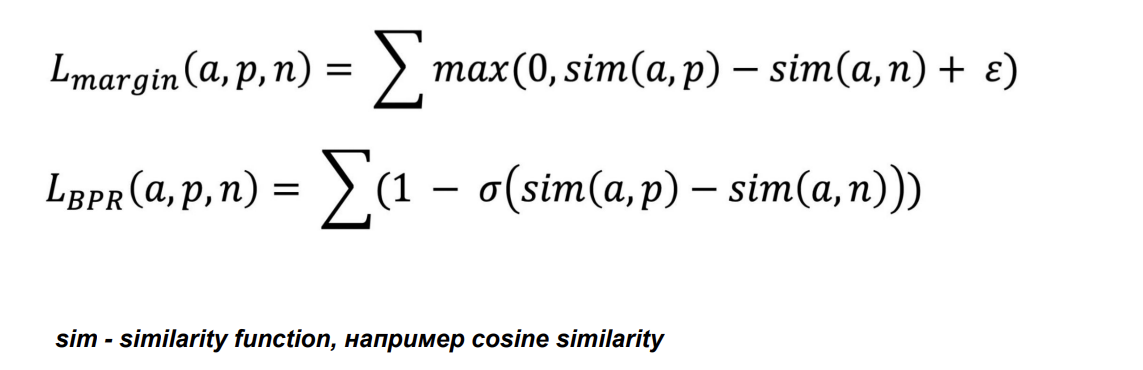





In [ ]:
def bpr_loss(a, pos, neg) -> torch.Tensor:
    sim_a_pos = F.cosine_similarity(a, pos)
    sim_a_neg = F.cosine_similarity(a, neg)
    losses = 1 - F.sigmoid(sim_a_pos - sim_a_neg)
    return torch.sum(losses)

Датасет


In [ ]:
class RecDataset(Dataset):
    def __init__(
        self,
        interactions_df: pd.DataFrame,
        users_int_vec: np.ndarray,
        users_cat_vec: np.ndarray,
        items_vec: np.ndarray,
        uid_to_watched_iids: dict[int, list[int]],
        last_n_items: int = 7,
        unq_u_ids: np.ndarray = None,
    ):
        self.users_cat_vec = users_cat_vec
        self.users_int_vec = users_int_vec
        self.items_vec = items_vec
        self.uid_to_watched_iids = uid_to_watched_iids
        self.last_n_items = last_n_items

        if unq_u_ids is None:
            unq_u_ids = interactions_df["uid"].unique()
        
        np.random.shuffle(unq_u_ids)
        self.unq_u_ids = unq_u_ids

    def __getitem__(self, index: int):
        uid = self.unq_u_ids[index]

        user_cat_features = self.users_cat_vec[uid]
        user_int_features = self.users_int_vec[uid]

        watched_iids = uid_to_watched_iids[uid]
        pos_item_index = np.random.randint(
            low=self.last_n_items,
            high=len(watched_iids)
        )
        watched_items_features = np.array([
            self.items_vec[iid]
                for iid in watched_iids[pos_item_index - self.last_n_items : pos_item_index]
        ])

        pos_iid = watched_iids[pos_item_index]
        pos_item_features = self.items_vec[pos_iid]

        neg_iid = np.random.randint(len(self.items_vec))
        neg_item_features = self.items_vec[neg_iid]

        return (
            user_cat_features,
            user_int_features,
            watched_items_features,
            pos_item_features,
            neg_item_features,
        )
        
    def __len__(self):
        return len(self.unq_u_ids)


Модель DSSM

In [ ]:
class TemporalDSSM(nn.Module):
    def __init__(
        self,
        u_cat_dim: int,
        u_cat1_dim: int,
        u_cat2_dim: int,
        u_int_dim: int,
        u_int1_dim: int,
        u_int2_dim: int,
        u_temp_dim: int,
        if_dim: int,
        if1_dim: int,
        if2_dim: int,
        final_dim: int,
        dropout: float,
    ):
        super().__init__()
        # Полносвязные слои с остаточным соединением для айтема
        self.item_layer1 = nn.Sequential(
            nn.Linear(if_dim, if1_dim),
            nn.BatchNorm1d(if1_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        self.item_layer2 = nn.Sequential(
            nn.Linear(if1_dim, if2_dim),
            nn.BatchNorm1d(if2_dim, ),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        # item embedding
        self.item_emb = nn.Sequential(
            nn.Linear(if2_dim, final_dim),
            nn.BatchNorm1d(final_dim),
            nn.Tanh(),
        )
        # Полносвязные слои с остаточным соединением для пользователя
        self.user_cat1 = nn.Sequential(
            nn.Linear(u_cat_dim, u_cat1_dim),
            nn.BatchNorm1d(u_cat1_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        self.user_cat2 = nn.Sequential(
            nn.Linear(u_cat1_dim, u_cat2_dim),
            nn.BatchNorm1d(u_cat2_dim),
            nn.Tanh(),
            nn.Dropout(dropout)
        )
        self.user_int1 = nn.Sequential(
            nn.Linear(u_int_dim, u_int1_dim),
            nn.BatchNorm1d(u_int1_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        self.user_int2 = nn.Sequential(
            nn.Linear(u_int1_dim, u_int2_dim),
            nn.BatchNorm1d(u_int2_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        )
        # Рекуррентный слой для просмотренных айтемов пользователя
        # E = {размерность векторов айтемов} = if_dim
        # H = {размерность скрытого состояния} = u_temp_dim
        # L = {длина последовательности}. B = {размер пакета}.
        # Вход (B, L, E). Выход (B, L, H), (num_layers, B, H).
        self.user_temp = (
            nn.LSTM(
                if_dim, u_temp_dim, 
                num_layers=2,
                dropout=dropout,
                batch_first=True
            )
        )
        # user embedding
        self.user_emb = nn.Sequential(
            nn.Linear(u_cat2_dim + u_int2_dim + u_temp_dim, final_dim),
            nn.BatchNorm1d(final_dim),
            nn.Tanh()
        )

        # self.cosine = nn.CosineSimilarity()
        # self.sigmoid = nn.Sigmoid()
    
    def forward(
        self, 
        user_category_features,
        user_interaction_features,
        watched_items_features, # (B, L=7, E)
        pos_item_features,      # (B, E)
        neg_item_features,      # (B, E)
    ):
        # User embeding
        user_cat1 = self.user_cat1(user_category_features)
        user_cat2 = self.user_cat2(user_cat1)
        user_cat2 += user_cat1

        user_int1 = self.user_int1(user_interaction_features)
        user_int2 = self.user_int2(user_int1)
        user_int2 += user_int1
        
        _, user_temp = self.user_temp(watched_items_features)

        user_emb = torch.cat((user_cat2, user_int2, user_temp[-1]), 1)
        user_emb = self.user_emb(user_emb)
        
        # Positive item embedding
        pos_item_layer1 = self.item_layer1(pos_item_features)
        pos_item_layer2 = self.item_layer2(pos_item_layer1)
        pos_item_layer2 += pos_item_layer1

        pos_item_emb = self.item_emb(pos_item_layer2)

        # Negative item embedding
        neg_item_layer1 = self.item_layer1(neg_item_features)
        neg_item_layer2 = self.item_layer2(neg_item_layer1)
        neg_item_layer2 += neg_item_layer1

        neg_item_emb = self.item_emb(neg_item_layer2)

        return user_emb, pos_item_emb, neg_item_emb


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
unq_u_ids = interactions_df["uid"].unique()
np.random.shuffle(unq_u_ids)

test_size = 0.1

train_u_ids = unq_u_ids[:]
test_u_ids = unq_u_ids[ : int(len(unq_u_ids) * test_size) ] 

train_data = RecDataset(
    interactions_df = interactions_df,
    users_int_vec = interactions_vec,
    users_cat_vec = users_category_vec,
    items_vec = items_vec,
    uid_to_watched_iids = uid_to_watched_iids,
    last_n_items = 7,
    unq_u_ids = train_u_ids,
)
test_data = RecDataset(
    interactions_df = interactions_df,
    users_int_vec = interactions_vec,
    users_cat_vec = users_category_vec,
    items_vec = items_vec,
    uid_to_watched_iids = uid_to_watched_iids,
    last_n_items = 7,
    unq_u_ids = test_u_ids,
)

train_loader = DataLoader(
    train_data,
    batch_size=256,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
)
test_loader = DataLoader(
    test_data,
    batch_size=256,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
)

In [ ]:
print(f"{interactions_vec.shape} - user interactions vectors")
print(f"{users_category_vec.shape} - user category features")
print(f"{items_vec.shape} - item vectors")
print(f"{len(uid_to_watched_iids)} - user watched items lists")

(103074, 8836) - user interactions vectors
(103074, 19) - user category features
(8836, 1015) - item vectors
103074 - user watched items lists


In [ ]:
net = TemporalDSSM(
    u_cat_dim = 19,
    u_cat1_dim = 64,
    u_cat2_dim = 64,
    u_int_dim = 8836,
    u_int1_dim = 256,
    u_int2_dim = 256,
    u_temp_dim = 256,
    if_dim = 1015,
    if1_dim = 128,
    if2_dim = 128,
    final_dim = 128,
    dropout=0.5,
)
net.to(device)

optimizer = optim.Adam(net.parameters())
criterion = bpr_loss

In [ ]:
def process_epoch(
    net: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: tp.Callable,
    device: torch.device,
    process: str, # "train", "eval"
):
    epoch_loss = 0.
    n_batches = len(loader)
    
    if process == "train":
        net.train()
    elif process == "eval":
        net.eval()
    
    with torch.set_grad_enabled(process == "train"):
        for batch in tqdm(loader, total=n_batches):
            user_cat_features = batch[0].to(device)
            user_int_features = batch[1].to(device)
            watched_items_features = batch[2].to(device)
            pos_item_features = batch[3].to(device)
            neg_item_features = batch[4].to(device)

            u_emb, pos_u_emb, neg_i_emb = net(
                user_category_features = user_cat_features,
                user_interaction_features = user_int_features,
                watched_items_features = watched_items_features, # (L, B, E)
                pos_item_features = pos_item_features,
                neg_item_features = neg_item_features,
            )
            loss = criterion(u_emb, pos_u_emb, neg_i_emb)

            if process == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            
    return epoch_loss / n_batches

In [ ]:
train_losses = []
valid_losses = []
best_valid_loss = float("inf")
best_model_state: tp.Dict[str, torch.Tensor] = {}
for epoch in range(100):
    print(f"Epoch {epoch + 1} started")

    train_loss = process_epoch(net, train_loader, optimizer, criterion, device, "train")
    valid_loss = process_epoch(net, test_loader, optimizer, criterion, device, "eval")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_state = net.state_dict()

    print(f"Epoch: {epoch + 1:02}")
    print(
        f"\t Train loss: {train_loss:.3f}"
        f"\n\t Valid loss: {valid_loss:.3f}"
    )

net.load_state_dict(best_model_state)
torch.save(best_model_state, "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/best_model_dssm_100.pt")

Epoch 1 started


100%|██████████| 41/41 [00:01<00:00, 21.78it/s]


Epoch: 01
	 Train loss: 105.996
	 Valid loss: 99.870
Epoch 2 started


100%|██████████| 41/41 [00:02<00:00, 17.10it/s]


Epoch: 02
	 Train loss: 101.964
	 Valid loss: 98.382
Epoch 3 started


100%|██████████| 41/41 [00:01<00:00, 21.66it/s]


Epoch: 03
	 Train loss: 100.434
	 Valid loss: 96.649
Epoch 4 started


100%|██████████| 41/41 [00:01<00:00, 21.68it/s]


Epoch: 04
	 Train loss: 99.817
	 Valid loss: 96.498
Epoch 5 started


100%|██████████| 41/41 [00:02<00:00, 14.38it/s]


Epoch: 05
	 Train loss: 98.623
	 Valid loss: 96.215
Epoch 6 started


100%|██████████| 41/41 [00:03<00:00, 12.36it/s]


Epoch: 06
	 Train loss: 97.262
	 Valid loss: 99.122
Epoch 7 started


100%|██████████| 41/41 [00:02<00:00, 14.04it/s]


Epoch: 07
	 Train loss: 95.277
	 Valid loss: 103.288
Epoch 8 started


100%|██████████| 41/41 [00:02<00:00, 19.18it/s]


Epoch: 08
	 Train loss: 88.575
	 Valid loss: 121.413
Epoch 9 started


100%|██████████| 41/41 [00:02<00:00, 17.88it/s]


Epoch: 09
	 Train loss: 80.089
	 Valid loss: 135.634
Epoch 10 started


100%|██████████| 41/41 [00:03<00:00, 12.96it/s]


Epoch: 10
	 Train loss: 70.462
	 Valid loss: 135.440
Epoch 11 started


100%|██████████| 41/41 [00:02<00:00, 14.71it/s]


Epoch: 11
	 Train loss: 65.176
	 Valid loss: 140.029
Epoch 12 started


100%|██████████| 41/41 [00:01<00:00, 21.83it/s]


Epoch: 12
	 Train loss: 62.720
	 Valid loss: 144.332
Epoch 13 started


100%|██████████| 41/41 [00:02<00:00, 16.94it/s]


Epoch: 13
	 Train loss: 61.841
	 Valid loss: 135.598
Epoch 14 started


100%|██████████| 41/41 [00:03<00:00, 12.66it/s]


Epoch: 14
	 Train loss: 61.087
	 Valid loss: 122.766
Epoch 15 started


100%|██████████| 41/41 [00:01<00:00, 21.57it/s]


Epoch: 15
	 Train loss: 60.638
	 Valid loss: 137.368
Epoch 16 started


100%|██████████| 41/41 [00:02<00:00, 14.26it/s]


Epoch: 16
	 Train loss: 60.374
	 Valid loss: 135.997
Epoch 17 started


100%|██████████| 41/41 [00:01<00:00, 21.39it/s]


Epoch: 17
	 Train loss: 59.962
	 Valid loss: 132.085
Epoch 18 started


100%|██████████| 41/41 [00:01<00:00, 21.76it/s]


Epoch: 18
	 Train loss: 60.124
	 Valid loss: 146.618
Epoch 19 started


100%|██████████| 41/41 [00:01<00:00, 20.89it/s]


Epoch: 19
	 Train loss: 59.961
	 Valid loss: 132.017
Epoch 20 started


100%|██████████| 41/41 [00:01<00:00, 21.45it/s]


Epoch: 20
	 Train loss: 59.853
	 Valid loss: 136.034
Epoch 21 started


100%|██████████| 41/41 [00:02<00:00, 16.19it/s]


Epoch: 21
	 Train loss: 59.522
	 Valid loss: 131.968
Epoch 22 started


100%|██████████| 41/41 [00:02<00:00, 19.51it/s]


Epoch: 22
	 Train loss: 59.241
	 Valid loss: 132.285
Epoch 23 started


100%|██████████| 41/41 [00:01<00:00, 22.19it/s]


Epoch: 23
	 Train loss: 59.127
	 Valid loss: 128.465
Epoch 24 started


100%|██████████| 41/41 [00:02<00:00, 16.56it/s]


Epoch: 24
	 Train loss: 59.066
	 Valid loss: 126.700
Epoch 25 started


100%|██████████| 41/41 [00:01<00:00, 21.88it/s]


Epoch: 25
	 Train loss: 58.943
	 Valid loss: 133.883
Epoch 26 started


100%|██████████| 41/41 [00:02<00:00, 18.32it/s]


Epoch: 26
	 Train loss: 58.771
	 Valid loss: 137.323
Epoch 27 started


100%|██████████| 41/41 [00:03<00:00, 13.65it/s]


Epoch: 27
	 Train loss: 58.908
	 Valid loss: 136.616
Epoch 28 started


100%|██████████| 41/41 [00:02<00:00, 16.60it/s]


Epoch: 28
	 Train loss: 58.889
	 Valid loss: 139.797
Epoch 29 started


100%|██████████| 41/41 [00:02<00:00, 16.65it/s]


Epoch: 29
	 Train loss: 58.530
	 Valid loss: 144.157
Epoch 30 started


100%|██████████| 41/41 [00:01<00:00, 21.68it/s]


Epoch: 30
	 Train loss: 58.857
	 Valid loss: 142.904
Epoch 31 started


100%|██████████| 41/41 [00:01<00:00, 21.48it/s]


Epoch: 31
	 Train loss: 58.848
	 Valid loss: 140.366
Epoch 32 started


100%|██████████| 41/41 [00:01<00:00, 21.72it/s]


Epoch: 32
	 Train loss: 58.587
	 Valid loss: 134.654
Epoch 33 started


100%|██████████| 41/41 [00:01<00:00, 21.93it/s]


Epoch: 33
	 Train loss: 58.773
	 Valid loss: 141.456
Epoch 34 started


100%|██████████| 41/41 [00:02<00:00, 18.33it/s]


Epoch: 34
	 Train loss: 58.617
	 Valid loss: 132.105
Epoch 35 started


100%|██████████| 41/41 [00:01<00:00, 20.83it/s]


Epoch: 35
	 Train loss: 58.658
	 Valid loss: 143.206
Epoch 36 started


100%|██████████| 41/41 [00:01<00:00, 21.90it/s]


Epoch: 36
	 Train loss: 58.356
	 Valid loss: 132.568
Epoch 37 started


100%|██████████| 41/41 [00:02<00:00, 13.86it/s]


Epoch: 37
	 Train loss: 58.513
	 Valid loss: 138.070
Epoch 38 started


100%|██████████| 41/41 [00:01<00:00, 21.77it/s]


Epoch: 38
	 Train loss: 58.617
	 Valid loss: 136.917
Epoch 39 started


100%|██████████| 41/41 [00:01<00:00, 21.68it/s]


Epoch: 39
	 Train loss: 58.580
	 Valid loss: 136.473
Epoch 40 started


100%|██████████| 41/41 [00:02<00:00, 18.38it/s]


Epoch: 40
	 Train loss: 58.253
	 Valid loss: 141.083
Epoch 41 started


100%|██████████| 41/41 [00:01<00:00, 21.89it/s]


Epoch: 41
	 Train loss: 58.549
	 Valid loss: 144.885
Epoch 42 started


100%|██████████| 41/41 [00:02<00:00, 19.84it/s]


Epoch: 42
	 Train loss: 58.361
	 Valid loss: 119.222
Epoch 43 started


100%|██████████| 41/41 [00:01<00:00, 22.10it/s]


Epoch: 43
	 Train loss: 58.207
	 Valid loss: 141.718
Epoch 44 started


100%|██████████| 41/41 [00:01<00:00, 21.55it/s]


Epoch: 44
	 Train loss: 58.333
	 Valid loss: 135.105
Epoch 45 started


100%|██████████| 41/41 [00:02<00:00, 13.80it/s]


Epoch: 45
	 Train loss: 58.501
	 Valid loss: 132.345
Epoch 46 started


100%|██████████| 41/41 [00:01<00:00, 21.93it/s]


Epoch: 46
	 Train loss: 58.186
	 Valid loss: 128.141
Epoch 47 started


100%|██████████| 41/41 [00:01<00:00, 21.78it/s]


Epoch: 47
	 Train loss: 58.286
	 Valid loss: 142.378
Epoch 48 started


100%|██████████| 41/41 [00:02<00:00, 14.18it/s]


Epoch: 48
	 Train loss: 58.422
	 Valid loss: 123.602
Epoch 49 started


100%|██████████| 41/41 [00:01<00:00, 21.90it/s]


Epoch: 49
	 Train loss: 58.205
	 Valid loss: 133.506
Epoch 50 started


100%|██████████| 41/41 [00:01<00:00, 21.73it/s]


Epoch: 50
	 Train loss: 58.303
	 Valid loss: 122.899
Epoch 51 started


100%|██████████| 41/41 [00:02<00:00, 16.25it/s]


Epoch: 51
	 Train loss: 58.067
	 Valid loss: 137.739
Epoch 52 started


100%|██████████| 41/41 [00:01<00:00, 22.30it/s]


Epoch: 52
	 Train loss: 58.059
	 Valid loss: 134.519
Epoch 53 started


100%|██████████| 41/41 [00:01<00:00, 21.71it/s]


Epoch: 53
	 Train loss: 58.500
	 Valid loss: 137.177
Epoch 54 started


100%|██████████| 41/41 [00:01<00:00, 20.78it/s]


Epoch: 54
	 Train loss: 58.214
	 Valid loss: 135.664
Epoch 55 started


100%|██████████| 41/41 [00:01<00:00, 21.68it/s]


Epoch: 55
	 Train loss: 58.242
	 Valid loss: 139.102
Epoch 56 started


100%|██████████| 41/41 [00:02<00:00, 17.92it/s]


Epoch: 56
	 Train loss: 58.093
	 Valid loss: 131.962
Epoch 57 started


100%|██████████| 41/41 [00:01<00:00, 21.70it/s]


Epoch: 57
	 Train loss: 58.094
	 Valid loss: 141.623
Epoch 58 started


100%|██████████| 41/41 [00:01<00:00, 21.83it/s]


Epoch: 58
	 Train loss: 58.072
	 Valid loss: 139.777
Epoch 59 started


100%|██████████| 41/41 [00:02<00:00, 13.91it/s]


Epoch: 59
	 Train loss: 57.962
	 Valid loss: 118.025
Epoch 60 started


100%|██████████| 41/41 [00:01<00:00, 21.94it/s]


Epoch: 60
	 Train loss: 58.009
	 Valid loss: 142.920
Epoch 61 started


100%|██████████| 41/41 [00:01<00:00, 21.74it/s]


Epoch: 61
	 Train loss: 57.867
	 Valid loss: 142.385
Epoch 62 started


100%|██████████| 41/41 [00:03<00:00, 13.65it/s]


Epoch: 62
	 Train loss: 58.205
	 Valid loss: 136.093
Epoch 63 started


100%|██████████| 41/41 [00:01<00:00, 21.77it/s]


Epoch: 63
	 Train loss: 58.017
	 Valid loss: 134.468
Epoch 64 started


100%|██████████| 41/41 [00:01<00:00, 21.77it/s]


Epoch: 64
	 Train loss: 58.301
	 Valid loss: 141.623
Epoch 65 started


100%|██████████| 41/41 [00:02<00:00, 15.99it/s]


Epoch: 65
	 Train loss: 57.900
	 Valid loss: 141.697
Epoch 66 started


100%|██████████| 41/41 [00:01<00:00, 21.46it/s]


Epoch: 66
	 Train loss: 57.782
	 Valid loss: 146.255
Epoch 67 started


100%|██████████| 41/41 [00:01<00:00, 21.86it/s]


Epoch: 67
	 Train loss: 58.052
	 Valid loss: 142.245
Epoch 68 started


100%|██████████| 41/41 [00:02<00:00, 14.97it/s]


Epoch: 68
	 Train loss: 58.032
	 Valid loss: 141.854
Epoch 69 started


100%|██████████| 41/41 [00:01<00:00, 21.42it/s]


Epoch: 69
	 Train loss: 57.739
	 Valid loss: 138.801
Epoch 70 started


100%|██████████| 41/41 [00:02<00:00, 17.50it/s]


Epoch: 70
	 Train loss: 57.820
	 Valid loss: 130.344
Epoch 71 started


100%|██████████| 41/41 [00:01<00:00, 21.95it/s]


Epoch: 71
	 Train loss: 58.146
	 Valid loss: 133.738
Epoch 72 started


100%|██████████| 41/41 [00:01<00:00, 21.42it/s]


Epoch: 72
	 Train loss: 57.618
	 Valid loss: 138.567
Epoch 73 started


100%|██████████| 41/41 [00:01<00:00, 20.51it/s]


Epoch: 73
	 Train loss: 57.968
	 Valid loss: 141.091
Epoch 74 started


100%|██████████| 41/41 [00:01<00:00, 21.77it/s]


Epoch: 74
	 Train loss: 58.034
	 Valid loss: 143.868
Epoch 75 started


100%|██████████| 41/41 [00:02<00:00, 19.64it/s]


Epoch: 75
	 Train loss: 57.875
	 Valid loss: 129.586
Epoch 76 started


100%|██████████| 41/41 [00:01<00:00, 21.15it/s]


Epoch: 76
	 Train loss: 57.904
	 Valid loss: 142.197
Epoch 77 started


100%|██████████| 41/41 [00:01<00:00, 21.71it/s]


Epoch: 77
	 Train loss: 57.858
	 Valid loss: 141.828
Epoch 78 started


100%|██████████| 41/41 [00:02<00:00, 14.33it/s]


Epoch: 78
	 Train loss: 58.003
	 Valid loss: 136.389
Epoch 79 started


100%|██████████| 41/41 [00:01<00:00, 21.89it/s]


Epoch: 79
	 Train loss: 57.886
	 Valid loss: 141.626
Epoch 80 started


100%|██████████| 41/41 [00:01<00:00, 21.89it/s]


Epoch: 80
	 Train loss: 57.667
	 Valid loss: 130.414
Epoch 81 started


100%|██████████| 41/41 [00:02<00:00, 14.55it/s]


Epoch: 81
	 Train loss: 57.801
	 Valid loss: 142.854
Epoch 82 started


100%|██████████| 41/41 [00:01<00:00, 21.58it/s]


Epoch: 82
	 Train loss: 57.795
	 Valid loss: 141.821
Epoch 83 started


100%|██████████| 41/41 [00:01<00:00, 21.69it/s]


Epoch: 83
	 Train loss: 57.716
	 Valid loss: 134.605
Epoch 84 started


100%|██████████| 41/41 [00:02<00:00, 20.08it/s]


Epoch: 84
	 Train loss: 57.785
	 Valid loss: 129.170
Epoch 85 started


100%|██████████| 41/41 [00:01<00:00, 21.73it/s]


Epoch: 85
	 Train loss: 57.746
	 Valid loss: 138.049
Epoch 86 started


100%|██████████| 41/41 [00:02<00:00, 18.44it/s]


Epoch: 86
	 Train loss: 58.061
	 Valid loss: 141.194
Epoch 87 started


100%|██████████| 41/41 [00:01<00:00, 21.06it/s]


Epoch: 87
	 Train loss: 57.510
	 Valid loss: 143.514
Epoch 88 started


100%|██████████| 41/41 [00:01<00:00, 21.56it/s]


Epoch: 88
	 Train loss: 58.059
	 Valid loss: 139.437
Epoch 89 started


100%|██████████| 41/41 [00:03<00:00, 13.18it/s]


Epoch: 89
	 Train loss: 57.655
	 Valid loss: 137.570
Epoch 90 started


100%|██████████| 41/41 [00:01<00:00, 21.85it/s]


Epoch: 90
	 Train loss: 57.974
	 Valid loss: 133.721
Epoch 91 started


100%|██████████| 41/41 [00:01<00:00, 21.57it/s]


Epoch: 91
	 Train loss: 57.490
	 Valid loss: 143.673
Epoch 92 started


100%|██████████| 41/41 [00:02<00:00, 15.50it/s]


Epoch: 92
	 Train loss: 57.785
	 Valid loss: 136.119
Epoch 93 started


100%|██████████| 41/41 [00:01<00:00, 21.74it/s]


Epoch: 93
	 Train loss: 57.791
	 Valid loss: 139.734
Epoch 94 started


100%|██████████| 41/41 [00:01<00:00, 21.74it/s]


Epoch: 94
	 Train loss: 57.747
	 Valid loss: 143.927
Epoch 95 started


100%|██████████| 41/41 [00:02<00:00, 18.91it/s]


Epoch: 95
	 Train loss: 57.641
	 Valid loss: 135.899
Epoch 96 started


100%|██████████| 41/41 [00:01<00:00, 21.48it/s]


Epoch: 96
	 Train loss: 57.725
	 Valid loss: 133.867
Epoch 97 started


100%|██████████| 41/41 [00:02<00:00, 19.45it/s]


Epoch: 97
	 Train loss: 57.621
	 Valid loss: 144.670
Epoch 98 started


100%|██████████| 41/41 [00:01<00:00, 21.80it/s]


Epoch: 98
	 Train loss: 57.487
	 Valid loss: 138.404
Epoch 99 started


100%|██████████| 41/41 [00:01<00:00, 21.45it/s]


Epoch: 99
	 Train loss: 57.781
	 Valid loss: 138.170
Epoch 100 started


100%|██████████| 41/41 [00:02<00:00, 15.37it/s]

Epoch: 100
	 Train loss: 57.710
	 Valid loss: 128.688


## Вектора пользователей и айтемов из модели dssm

In [ ]:
net = TemporalDSSM(
    u_cat_dim = 19,
    u_cat1_dim = 64,
    u_cat2_dim = 64,
    u_int_dim = 8836,
    u_int1_dim = 256,
    u_int2_dim = 256,
    u_temp_dim = 256,
    if_dim = 1015,
    if1_dim = 128,
    if2_dim = 128,
    final_dim = 128,
    dropout=0.5,
)
net.load_state_dict(torch.load("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/best_model_dssm.pt"))
device = torch.device("cpu")
net.to(device)
net.eval();

In [ ]:
# Заглушки
mock_u_cat = torch.zeros((1, users_category_vec.shape[1]))
mock_u_int = torch.zeros((1, interactions_vec.shape[1]))
mock_last_w_items = torch.zeros((1, 7, items_vec.shape[1]))
mock_item = torch.zeros((1, items_vec.shape[1]))

In [ ]:
del ohe_feat_df  #, interactions_vec, users_category_vec, items_vec

Вектора пользователей

In [ ]:
dssm_user_vectors = np.zeros((interactions_vec.shape[0], 128))

for uid in tqdm(range(interactions_vec.shape[0])):
    last_7_iids = uid_to_watched_iids[uid][-7:]
    last_7_items_vec = np.array([items_vec[iid] for iid in last_7_iids])

    with torch.no_grad():
        dssm_user_vectors[uid] = net(
            user_category_features = torch.as_tensor(users_category_vec[uid]).reshape(1,-1),
            user_interaction_features = torch.as_tensor(interactions_vec[uid]).reshape(1,-1),
            watched_items_features = torch.as_tensor(last_7_items_vec).reshape(1, 7, -1),
            pos_item_features = mock_item,
            neg_item_features = mock_item,
        )[0].numpy()

100%|██████████| 103074/103074 [05:19<00:00, 322.97it/s]


Вектора айтемов

In [ ]:
dssm_item_vectors = np.zeros((items_vec.shape[0], 128))

for iid in tqdm(range(items_vec.shape[0])):
    with torch.no_grad():
        dssm_item_vectors[iid] = net(
            user_category_features = mock_u_cat,
            user_interaction_features = mock_u_int,
            watched_items_features = mock_last_w_items,
            pos_item_features = torch.as_tensor(items_vec[iid]).reshape(1,-1),
            neg_item_features = mock_item,
        )[1].numpy()

100%|██████████| 8836/8836 [00:26<00:00, 332.52it/s]


In [ ]:
ith open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/dssm_user_vectors.pickle", "wb") as f:
    pickle.dump(dssm_user_vectors, f, pickle.HIGHEST_PROTOCOL)
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/dssm_item_vectors.pickle", "wb") as f:
    pickle.dump(dssm_item_vectors, f, pickle.HIGHEST_PROTOCOL)

## HNSW индекс для быстрого поиска

In [89]:
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/dssm_user_vectors.pickle", "rb") as f:
    dssm_user_vectors = pickle.load(f)
with open("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/dssm_item_vectors.pickle", "rb") as f:
    dssm_item_vectors = pickle.load(f)

In [90]:
dssm_user_vectors.shape, dssm_item_vectors.shape

((103074, 128), (8836, 128))

In [75]:
max_elements, dim = dssm_item_vectors.shape

index = hnswlib.Index('cosine', dim)

In [76]:
# Параметры Индекса
M = 30 # adjustable
efC = 25 # adjustable
# Параметры Поиска по индексу
efS = 30 # adjustable

index.init_index(max_elements, M, efC)

index.add_items(dssm_item_vectors)

In [ ]:
index.save_index("/content/drive/MyDrive/RecSys MTC/NNs/DSSM/index.hnsw")

Минимальная проверка рекомендаций

In [ ]:
index.set_ef(efS)

test_uid = 30000
pred_iids = index.knn_query(dssm_user_vectors[test_uid], k = 10, num_threads=2)[0][0]
pred_iids

array([ 982, 3790, 2234,  746, 7051, 2558, 6271, 1831, 7494,  697],
      dtype=uint64)

In [ ]:
items_df[
    (items_df.item_id == iid_to_item_id[pred_iids[0]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[1]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[2]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[3]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[4]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[5]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[6]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[7]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[8]]) | \
    (items_df.item_id == iid_to_item_id[pred_iids[9]])
 ][["item_id", "title", "genres"]]

,item_id,title,genres
2123,3441,скрытая угроза,"триллеры, криминал, детективы"
2129,7117,игры без мяча,"ужасы, фэнтези, детективы"
2543,14000,афера по-английски,"драмы, криминал"
2982,1852,ноль,"фантастика, фэнтези, комедии"
9311,11754,kingsman: секретная служба,"боевики, криминал, приключения, комедии"
9941,1336,бугалу и грэхэм,"драмы, комедии"
10427,13199,возвращение,драмы
11263,1423,виктория,"семейное, комедии"
12856,4162,закрой глаза,"фантастика, фэнтези"
14450,4766,ералаш выпуск №21,семейное


In [ ]:
interactions_df[interactions_df.user_id == uid_to_user_id[test_uid]] \
    .merge(items_df[["item_id", "title", "genres"]], on="item_id")[["uid", "item_id", "title", "genres", "watched_pct", "last_watch_dt"]].sort_values("last_watch_dt")

,uid,item_id,title,genres,watched_pct,last_watch_dt
4,30000,4417,хищник 2,"боевики, ужасы, фантастика",23,2021-03-15
18,30000,1168,сплит,"драмы, спорт, комедии",74,2021-03-16
21,30000,849,дебошир,"историческое, биография, криминал, драмы, спор...",100,2021-03-17
2,30000,15997,сделано в италии,комедии,25,2021-03-18
8,30000,15531,секса много не бывает,"драмы, комедии",26,2021-03-18
5,30000,429,анон,"криминал, детективы, драмы, триллеры, фантастика",100,2021-03-20
35,30000,16291,лес самоубийц,"драмы, фэнтези, детективы",100,2021-03-21
20,30000,15656,далласский клуб покупателей,драмы,100,2021-03-21
9,30000,9937,12 лет рабства,"драмы, биография, историческое",100,2021-03-22
15,30000,9169,взаперти,"драмы, триллеры, детективы",16,2021-03-22


In [ ]:
users_df[users_df.user_id == uid_to_user_id[test_uid]]

,user_id,age,income,sex,kids_flg
311830,318796,age_18_24,income_20_40,M,False


## Код модели в сервисе

In [113]:
import pickle


class DSSMRecommender():
    def __init__(
        self, 
        index_path: str,
        user_vectors_path: str,
        user_id_to_uid_path: str,
        iid_to_item_id_path : str,
        uid_to_watched_iids_path: str, 
        dim: int = 128,
        efS : int = 50,
    ):
        self.index = hnswlib.Index("cosine", dim)
        self.index.load_index(index_path)
        self.index.set_ef(efS)

        with open(user_vectors_path, "rb") as f:
            self.dssm_user_vectors = pickle.load(f)
            
        with open(user_id_to_uid_path, "r") as f:
            self.user_id_to_uid = json.load(f)
        with open(iid_to_item_id_path, "r") as f:
            self.iid_to_item_id = json.load(f)

        with open(uid_to_watched_iids_path, "r") as f:
            self.uid_to_watched_iids = json.load(f)

    def predict(self, user_id: int, k_recs: int = 10):
        if str(user_id) not in self.user_id_to_uid:
            return None
        
        uid = self.user_id_to_uid[str(user_id)]

        watched = self.uid_to_watched_iids[str(uid)]
        
        pred_iids, _ = self.index.knn_query(self.dssm_user_vectors[uid], 
                                       k = k_recs + len(watched))
        answer_iids = []
        for iid in pred_iids[0]:
            if iid not in watched:
                answer_iids.append(iid)
            if len(answer_iids) == k_recs:
                break
        
        return [self.iid_to_item_id[str(iid)] for iid in answer_iids]

In [114]:
dssm_recommender = DSSMRecommender(
    index_path = "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/index.hnsw",
    user_vectors_path = "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/dssm_user_vectors.pickle",
    user_id_to_uid_path = "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/user_id_to_uid.json",
    iid_to_item_id_path = "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/iid_to_item_id.json",
    uid_to_watched_iids_path = "/content/drive/MyDrive/RecSys MTC/NNs/DSSM/uid_to_watched_iids.json", 
    dim = 128,
    efS = 50,
)

In [115]:
dssm_recommender.predict(318796)

[1852, 7117, 4162, 1423, 13199, 4766, 11754, 3441, 14000, 1336]

In [119]:
list(dssm_recommender.user_id_to_uid.keys())[:10]

['176549',
 '699317',
 '1016458',
 '884009',
 '988709',
 '5324',
 '15607',
 '927973',
 '215229',
 '896751']

Заметки после:

1. Поменяв функцию активации с ReLu на Tanh удалось улучшить эмбединги на выходе, но всё равно качество рекомендаций оставляет желать лучшего... например, сейчас почти каждому пользователю рекомендуется "ералаш выпуск №21"

2. Возможно для признаков айтема стоило преобразовать в вектор не текст описания фильма, а ключевые слова в столбце 'keywords'

3. Сейчас модель принимает прошлые просмотренные айтемы в виде больших векторов фичей айтемов. Возможно было бы лучше, если бы подавалась лишь последовательность из чисел item_id и эти же числа добавились бы в качестве еще одной фичи для признаков айтема 

4. Валидационные метрики не описывали улучшение модели на протяжении 100 эпох обучения.

5. Негативное семплирование - рандомное по всем айтемам. Положительное семплирование - тоже рандомное, но только среди просмотренных айтемов.

6. map@10=0.09347384, что не пробило скор модели baseline популярного по соц-дему (0.10116589)